In [1]:
import numpy as np
import scipy.stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
import matplotlib.font_manager as font_manager

del font_manager.weight_dict['roman']
font_manager._rebuild()

font = font_manager.FontProperties()
font.set_family('serif')
font.set_name('Times New Roman')
font.set_weight('light')

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'

# Avoid Type-3 fonts
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [3]:
def h(x: np.array, theta: float):
    """
    classifier with threshold

    Parameters
    ----------
    x: np.array
        input feature (1d array, float).
    theta : float
        threshold value.

    Returns
    -------
     y : np.array
         predicted class labels (1d array, int).
        
    """
    y = np.where(x >= theta, 1, -1).astype('i')
    return y

In [4]:
def generate_pairs(mu_p: float, sigma_p: float, mu_n: float, sigma_n: float, pi: float, m: int, seed: int):
    """
    method for generating pairwise examples 
    from two gaussian distributions with given parameters.

    Parameters
    ----------
    mu_p: float
        mean vector for positive distribution.
    sigma_p:
        standard deviation for positive distribution.
    mu_n: float
        mean vector for negative distribution.
    sigma_n:
        standard deviation for negative distribution.
    pi: float
        positive class proportion, i.e., p(y=1).
    m: int
        the number of generated pairs
    seed: int
        random seed

    Returns
    -------
    x1: np.array
        array of the first example
    x2: np.array
        array of the second example
    tau: np.array
        array of pairwise labels
        
    """
    np.random.seed(seed)
    assert sigma_p > 0 and sigma_n > 0 and 0 < pi < 1
    assert isinstance(m, int) and m > 0
    
    # number of positive/negative examples
    num_p = np.random.binomial(2 * m, pi)
    num_n = 2 * m - num_p
    
    # draw positive/negative examples from gaussian distributions 
    x_p = np.random.normal(loc=mu_p, scale=sigma_p, size=num_p)
    x_n = np.random.normal(loc=mu_n, scale=sigma_n, size=num_n)
    
    x = np.concatenate((x_p, x_n))
    y = np.concatenate((np.ones(num_p, dtype='i'), -np.ones(num_n, dtype='i')))
    
    perm_indices = np.random.permutation(2*m)
    
    x1, x2 = x[perm_indices[:m]], x[perm_indices[m:]]
    tau = y[perm_indices[:m]] * y[perm_indices[m:]]
    
    return x1, x2, tau

In [5]:
def compute_q_hat(x1: np.array, x2: np.array, tau: np.array, theta: float):
    """
    method for computing \hat{q}(h)

    Parameters
    ----------
    x1: np.array
        array of the first example
    x2: np.array
        array of the second example
    tau: np.array
        array of pairwise labels
    theta: float
        threshold parameter

    Returns
    -------
    q_hat: float
        
    """
    q_hat = 0.5 * np.where(h(x1, theta) == tau, 0, 1).mean() + 0.5 * np.where(h(x2, theta) == tau, 0, 1).mean()
    return q_hat

In [6]:
def sign(x: np.array):
    """
    sign function, +1 (x > 0) and -1 (x <= 0)
    """
    return np.where(x > 0, 1, -1)

In [7]:
def compute_error(mu_p: float, sigma_p: float, mu_n: float, sigma_n: float, pi: float, theta: float):
    """
    compute classification error for given parameters
    """
    error_p = scipy.stats.norm.cdf(theta, loc=mu_p, scale=sigma_p)
    error_n = 1 - scipy.stats.norm.cdf(theta, loc=mu_n, scale=sigma_n)
    error = pi * error_p + (1-pi) * error_n
    
    return error

In [8]:
def compute_optimal_sign(mu_p: float, sigma_p: float, mu_n: float, sigma_n: float, pi: float, theta: float):
    """
    compute the optimal class assignment for given distribution
    """
    error = compute_error(mu_p, sigma_p, mu_n, sigma_n, pi, theta)
    optimal_sign = sign(0.5 - error)
    return optimal_sign

In [9]:
# fixed parameters
mu_p = 1
sigma_p = 1
mu_n = -1
sigma_n = 2
num_trial = 10000

res = []

# simulation
for pi in [0.1, 0.4, 0.7]:
    for m in [2**i for i in range(1, 10, 2)]:
        for theta in range(-3, 4):
            num_success = 0
            # compute optimal sign
            s_star = compute_optimal_sign(mu_p=mu_p, sigma_p=sigma_p, mu_n=mu_n, sigma_n=sigma_n, pi=pi, theta=theta)
            
            for seed in range(num_trial):
                x1, x2, tau = generate_pairs(mu_p=mu_p, sigma_p=sigma_p, mu_n=mu_n, sigma_n=sigma_n, pi=pi, m=m, seed=seed)
                q_hat = compute_q_hat(x1, x2, tau, theta)
                s_hat = sign(pi - 0.5) * sign(0.5 - q_hat)

                if s_star == s_hat:
                    num_success += 1

            score = num_success/num_trial
            res.append({'pi': pi, 'm': m, 'theta': theta, 'score': score})

df = pd.DataFrame(res)

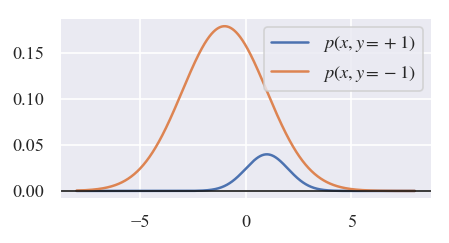

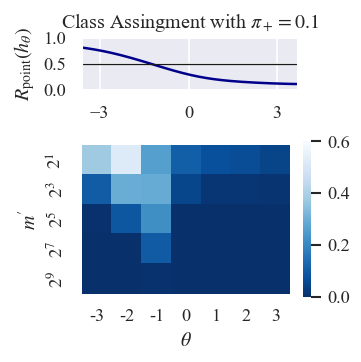

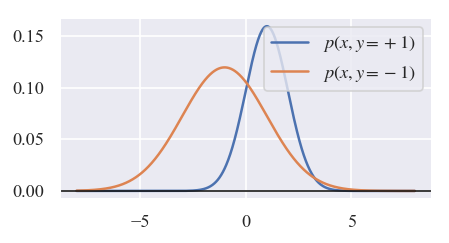

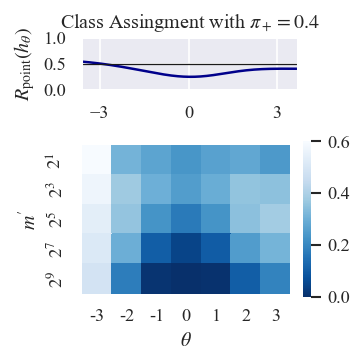

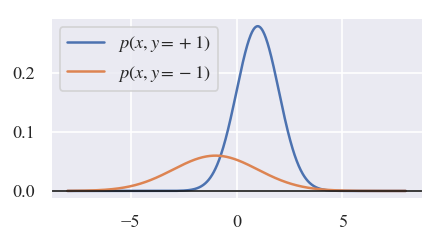

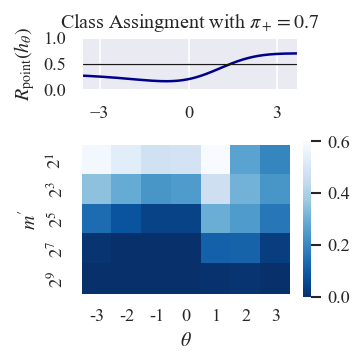

In [10]:
import matplotlib.gridspec as gridspec
import numpy as np

x = np.linspace(-3.5, 5.5, 1000)
# x = range(-3, 4)

r = 0.8

for pi in [0.1, 0.4, 0.7]:
    
    fig, ax = plt.subplots(figsize=(4, 2), dpi=120)
    x = np.linspace(-8, 8, 1000)
    ax.plot(x, pi * scipy.stats.norm.pdf(x, loc=mu_p, scale=sigma_p), label='$p(x, y=+1)$')
    ax.plot(x, (1-pi) * scipy.stats.norm.pdf(x, loc=mu_n, scale=sigma_n), label='$p(x, y=-1)$')
    ax.legend()
    ax.axhline(0, linewidth=1, c='k')
    
    
    fig = plt.figure(figsize=(3.5 * r, 5 * r), dpi=120)
    gs = gridspec.GridSpec(4, 6, hspace=1)

    ax1 = plt.subplot(gs[0, :-1])
    ax1.set_ylabel(r'$R_\mathrm{point}(h_{\theta})$')
    ax1.set_xticks([-3, 0, 3])
    ax1.set_yticks([0, 0.5, 1])
    ax1.set_ylim([0, 1])
    ax1.plot(x, compute_error(mu_p, sigma_p, mu_n, sigma_n, pi, x), linewidth=1.5, color='darkblue')
    ax1.axhline(0.5, linewidth=0.75, c='k')
    ax1.set_xlim([-3.6, 3.7])

    ax2 = plt.subplot(gs[1:-1, :])
    sns.heatmap(1 - df[df.pi == pi].pivot("m", "theta", "score"), cmap='Blues_r', square=True, ax=ax2, vmin=0, vmax=0.6)
    ax2.set_title('$\pi_+ = {}$'.format(pi))
    ax2.set_xlabel(r'$\theta$')
    ax2.set_ylabel(r'$m^\prime$')
    ax2.set_title('')
    ax2.set_yticklabels(['$2^{'+str(i)+'}$' for i in range(1, 10, 2)], rotation=90)
    
    fig.savefig("img/class_assinment_0{}.pdf".format(int(pi*10)), format='pdf', bbox_inches="tight")
    
    ax1.set_title("Class Assingment with $\pi_+={}$".format(pi))
    fig.savefig("img/class_assinment_0{}.png".format(int(pi*10)), format='png', bbox_inches="tight")